In [61]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
from torch.nn.functional import pad
from torch.nn.utils import clip_grad_value_
import matplotlib.pyplot as plt
from transformer_model import Transformer, SelfAttention, MLP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
device = "cuda"

In [51]:
dims = 2
seq_len = 10

In [52]:
def generate_data(batch_size, seq_len, dims):
    w = torch.normal(0, 1, size=(batch_size, dims), device=device)
    x = torch.normal(0, 1, size=(batch_size, seq_len, dims), device=device)
    y = torch.einsum("bp, blp -> bl", w, x)
    y = pad(input=y.unsqueeze(-1), pad=(0, dims-1), mode="constant", value=0.0)
    assert y.shape == (batch_size, seq_len, dims)
    interweaved = torch.stack((x, y), dim=2).view(batch_size, 2 * seq_len, dims)
    return x, y, w, interweaved

In [90]:
transformer = Transformer(
    num_layers=12,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=True,
    activation="relu"
).to(device)

loss_list = []
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.01)
for _ in trange(2000):
    x, y, w, interweaved = generate_data(batch_size=64, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    assert not torch.isnan(loss), loss
    optimizer.zero_grad()
    loss.backward()
    clip_grad_value_(transformer.parameters(), 0.1)
    optimizer.step()
    loss_list.append(loss.item())

  0%|          | 1/2000 [00:15<8:35:04, 15.46s/it]


AssertionError: tensor(nan, device='cuda:0', grad_fn=<MeanBackward0>)

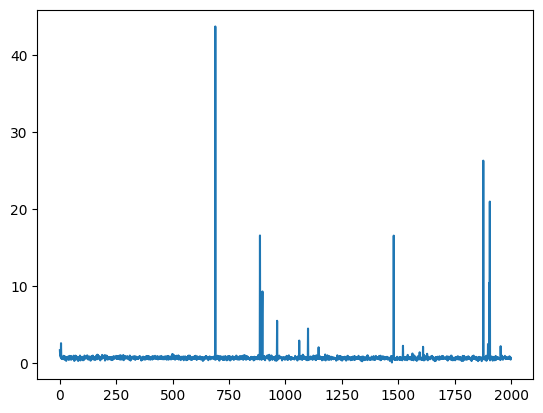

In [74]:
plt.plot(np.arange(len(loss_list)), np.log(loss_list))

In [75]:
transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

tensor([[-0.0725,  0.1924,  0.3451, -0.0758,  0.0506, -0.0207, -0.1333,  0.1062,
          0.0109,  0.0519]], device='cuda:0')
tensor([[ 0.5552, -0.7161,  1.8286,  0.6039,  0.0670,  0.4564,  0.5955, -0.8262,
         -1.0041, -1.5188]], device='cuda:0')
tensor(0.9008, device='cuda:0')


In [91]:
transformer = Transformer(
    num_layers=12,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=True,
    activation="softmax"
).to(device)

loss_list = []
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.01)
for _ in trange(2000):
    x, y, w, interweaved = generate_data(batch_size=64, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    assert not torch.isnan(loss), loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [01:06<00:00, 30.15it/s]


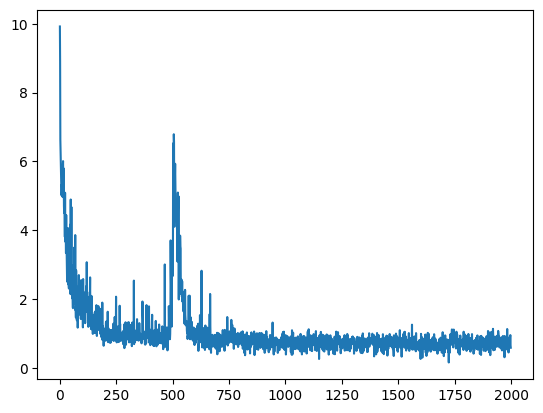

In [92]:
plt.plot(np.arange(len(loss_list)), np.log(loss_list))

In [93]:
transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

tensor([[0.0008, 0.0121, 0.0174, 0.0237, 0.1091, 0.0275, 0.0316, 0.0179, 0.0111,
         0.0259]], device='cuda:0')
tensor([[-4.6636, -1.1621,  2.3366, -4.0140,  0.0525, -2.3080, -1.7335, -5.1120,
         -3.7071,  3.4939]], device='cuda:0')
tensor(10.5557, device='cuda:0')


In [82]:
transformer = Transformer(
    num_layers=4,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=False,
    activation="softmax"
).to(device)

loss_list = []
optimizer = torch.optim.AdamW(transformer.parameters(), lr=0.01)
for _ in trange(2000):
    x, y, w, interweaved = generate_data(batch_size=64, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    assert not torch.isnan(loss), loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

100%|██████████| 2000/2000 [00:12<00:00, 159.61it/s]


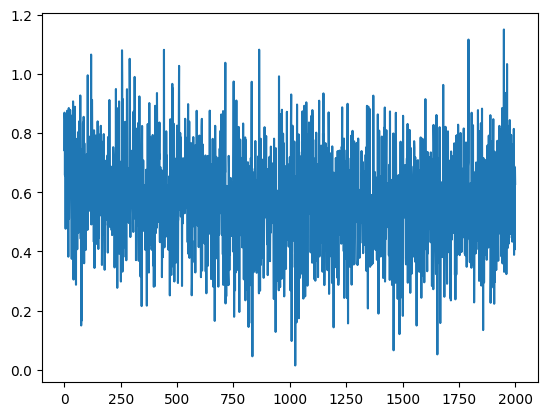

In [84]:
plt.plot(np.arange(len(loss_list)), np.log(loss_list))

In [83]:
transformer.eval()
with torch.no_grad():
    x, y, w, interweaved = generate_data(batch_size=8, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    print(pred)
    print(y[:, :, 0])
    print(loss)

tensor([[-0.0395, -0.0883, -0.2140, -0.2232, -0.0301,  0.4213,  0.1196,  0.0445,
         -0.0795, -0.0927],
        [-0.8830, -0.0119, -1.1570,  0.1991, -1.7837, -0.9334, -1.5862, -1.8754,
         -0.9945, -0.6174],
        [ 0.5114, -0.2758,  0.5599, -0.3890, -0.4473, -0.2766, -0.2910,  0.4659,
         -0.0863,  0.0739],
        [ 0.3969,  0.5972,  0.0658,  0.7972,  0.5230, -0.0092,  0.4881,  0.7050,
          0.2054,  0.2758],
        [ 0.0435,  0.0589, -0.3988,  0.0987, -0.4123, -0.4494, -0.0470,  0.1058,
         -0.8543, -1.3967],
        [ 0.2520,  0.3725, -0.0264, -0.1640,  0.3226,  0.0610,  0.0915,  0.2240,
          0.7299, -0.2651],
        [ 0.1417, -0.0213, -0.0484,  0.1778,  0.0608,  0.1861,  0.4078,  0.1136,
         -0.0980,  0.1816],
        [ 0.0289,  0.0297, -0.1278, -0.0770,  0.0646, -0.3329,  0.2761, -0.5606,
         -0.0762,  0.6702]], device='cuda:0')
tensor([[ 1.1517e+00, -2.2702e-01,  8.0680e-01, -1.1690e+00,  1.5266e+00,
         -2.3567e+00, -1.3116e+00,  

## Debug Causal Masking

In [41]:
# debug
transformer = Transformer(
    num_layers=4,
    input_dim=dims,
    num_heads=4,
    mlp_hidden_dim=16,
    is_causal=True,
    activation="softmax"
).to(device)

loss_list = []
optimizer = torch.optim.SGD(transformer.parameters(), lr=0.01)
for _ in trange(2000):
    x, y, w, interweaved = generate_data(batch_size=64, seq_len=seq_len, dims=dims)
    output = transformer(interweaved[:, :-1, :])
    pred = output[:, ::2, 0]
    loss = torch.mean((pred - y[:, :, 0]) ** 2)
    assert not torch.isnan(loss), loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

100%|██████████| 2000/2000 [00:31<00:00, 63.94it/s]


In [47]:
x, y, w, interweaved = generate_data(batch_size=1, seq_len=seq_len, dims=dims)
interweaved.requires_grad = True
output = transformer(interweaved[:, :-1, :])
optimizer.zero_grad()
output[0, 6, 0].backward()

In [48]:
interweaved.grad

tensor([[[ 0.0458,  0.0417,  0.0143, -0.0805, -0.0126],
         [-0.0267, -0.0321, -0.0375, -0.0080, -0.0703],
         [-0.0060, -0.0053, -0.0117,  0.0362,  0.0117],
         [-0.0244,  0.0378,  0.0060,  0.0579,  0.0712],
         [ 0.0247,  0.0800,  0.0448,  0.0526,  0.0424],
         [-0.0356,  0.0505, -0.0144,  0.0767,  0.0475],
         [ 0.0698, -0.1838,  0.0017, -0.0841, -0.1060],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0